In [1]:
# open the generated synthetic data file and read it as a python dictionary called data

import json

file = open('synthetic_dataset_with_time.txt', 'r')
text = file.read()
data = json.loads(text)


In [2]:
import emip_toolkit as EMTK

# find areas of interest (AOIs) once again
image_path = "./"
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")


# add tokens to AOIs 
file_path = "./"
aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()


import correction

# find the y coordinate of each line in the text
line_ys = correction.find_lines_Y(aoi)

In [3]:
import numpy as np
import drift_algorithms_osf as algo
from tqdm import tqdm

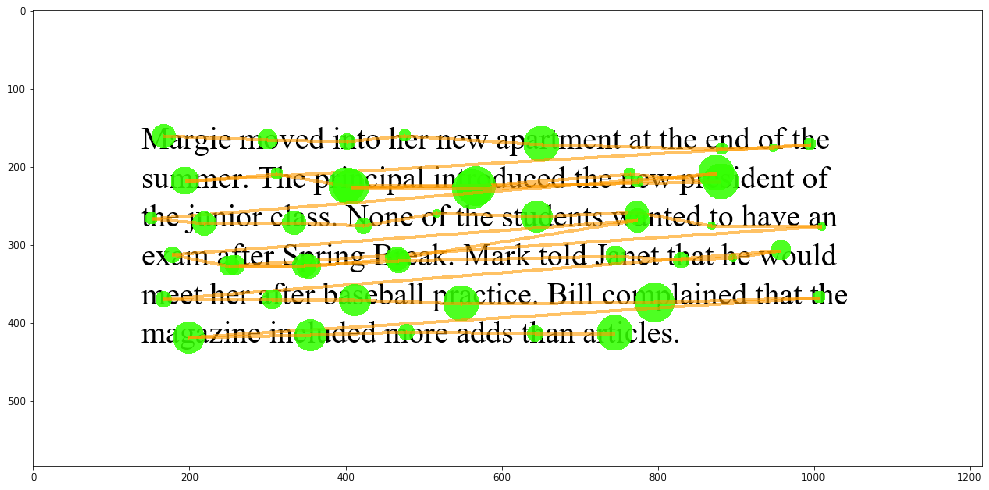

In [4]:
# draw original correct fixations

correction.draw_fixation('synthetic_text.png', data['robot1'].copy())

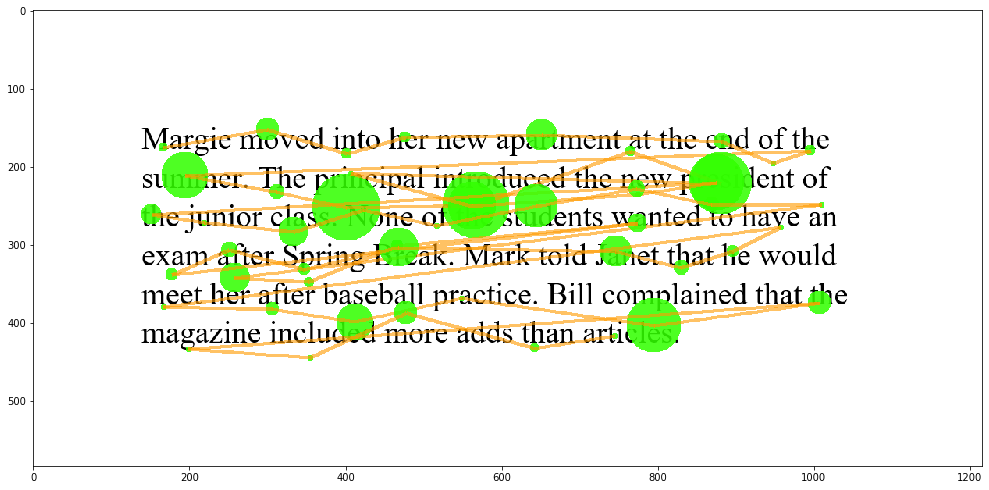

In [5]:
# generate noise over the correct trial

error_test = correction.error_noise(1, 30, 1, data['robot1'].copy())

# draw the trial with added error
correction.draw_fixation('synthetic_text.png', error_test)

0.98


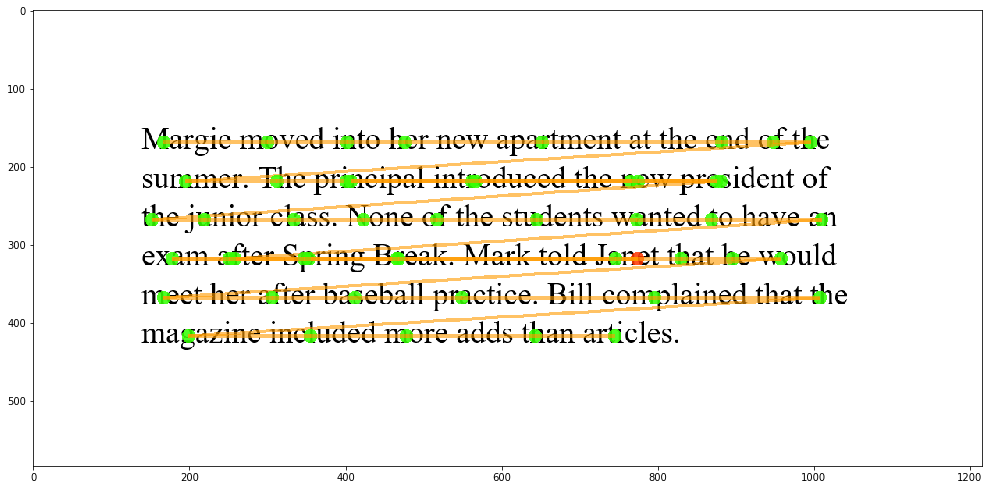

In [6]:
# find the center of each word, we need this for warp algorithm
word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

# warp correction
np_array = np.array(error_test.copy(), dtype=int)
durations = np.delete(np_array, 0, 1)
durations = np.delete(durations, 0, 1)
np_array = np.delete(np_array, 2, 1)

# run warp
warp_correction = algo.warp(np_array, word_centers)

# this is a cool function that checks the quality of the correction
percentage, match_list = correction.correction_quality(aoi, data['robot1'].copy(), warp_correction)
print(percentage)

# this is a cool function that draws the correction in red if the algorithm made a mistake
correction.draw_correction('synthetic_text.png', warp_correction, match_list)

This concludes the example I wanted to show you of running an error generator, then correcting the data, then seeing how well the correction algorithm did.  You will need to repeat the same concept for a bunch of algorithms in the next section.

# Comparing algorithms with Noise error:

In this example, I show you one type of erro "Noise" you will implement all 5 types and add skipping to your assessment.  Also, the code below runs only 4 algorithms, you will add the remaining 6 algorithms to this assessment for each type of error. 

In [7]:
word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

In [8]:
duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)

In [9]:
import time

ct = lambda : int(time.time() * 1000)
class Timer():
    def __init__(self):
        self.past = 0
    
    def start(self):
        self.past = ct()
        
    def end(self):
        x = ct() - self.past
        return x

In [21]:
algorithms = ["attach", "chain", "cluster", "compare", "merge", "regress", "segment", "split", "stretch", "warp"]

def run_error_on_algorithms(error_function, data, num_runs = 1):
    '''
    
    error_function should be a callable with the signature (error_probability, data)
    - error_probability is range(0,11) (ie, 0 through 10)
    - data is the ground truth data for noise to be added on
    - robot_index is the string key
    '''
    
    results = {alg:[[],[],[],[],[],[],[],[],[],[],[]] for alg in algorithms}

    word_center_algo = ["compare", "warp"]

    for robot_index in tqdm(range(num_runs)):
        robot_str = 'robot' + str(robot_index)
        print("starting robot_index", robot_index)
        for error_probability in range(0, 11):

            error_test = error_function(error_probability, data, robot_str)

            for alg in algorithms:
                error_test_copy = np.array(error_test.copy())
                if alg in word_center_algo:
                    model_guess = getattr(algo, alg)(error_test_copy[:,:2], word_centers)
                else:
                    model_guess = getattr(algo, alg)(error_test_copy, np.array(line_ys))

                #print(aoi.shape, np.array(data["robot1"]).shape, model_guess.shape)
                percentage, match_list = correction.correction_quality(aoi, data[robot_str].copy(), model_guess)
                results[alg][error_probability].append(percentage)

            if percentage < 1:
                #correction.draw_correction('synthetic_text.png', warp_correction, match_list)
                print("robot:", robot_index, "    error probability:", error_probability)

    return results

import matplotlib.pyplot as plt


In [22]:
import statistics

def mean_error_group(results):
    new_list = []
    
    for result in results:
        new_list.append(statistics.mean(result))
        
    return new_list

In [26]:
def plot_results(mean_results):
    f, ax = plt.subplots()
    markers = ".ov^<>1234"
    for i, alg in enumerate(algorithms):
        ax.plot(mean_results[alg], marker=markers[i]) # color='Black', linewidth=1, marker='^')

    ax.set_legend(algorithms)
    ax.set_ylabel('accuracy')
    ax.set_xlabel('noise')

    x_ticks_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
    ax.set_xticks(range(0, 11), x_ticks_labels)

    return ax


In [27]:
def e2e_error(error_name, errof_f, data):
    results = run_error_on_algorithms(noise_error, data)
    mean_results = {alg:mean_error_group(results[alg]) for alg in algorithms}
    plot = plot_results(mean_results)

    for alg in algorithms:
        print(f"[{error_name}] mean {alg}:", statistics.mean(mean_noise_results[alg]))
        
    return {"error_name": error_name, "plot": plot, "results": results, "mean_results": mean_results}

  0%|          | 0/100 [00:00<?, ?it/s]

starting robot_index 0
robot: 0     error probability: 0
robot: 0     error probability: 1
robot: 0     error probability: 2
robot: 0     error probability: 3
robot: 0     error probability: 4
robot: 0     error probability: 5
robot: 0     error probability: 6
robot: 0     error probability: 7
robot: 0     error probability: 8
robot: 0     error probability: 9


  1%|          | 1/100 [00:35<58:51, 35.67s/it]

robot: 0     error probability: 10
starting robot_index 1
robot: 1     error probability: 0
robot: 1     error probability: 1
robot: 1     error probability: 2
robot: 1     error probability: 3
robot: 1     error probability: 4
robot: 1     error probability: 5
robot: 1     error probability: 6
robot: 1     error probability: 7
robot: 1     error probability: 8
robot: 1     error probability: 9


  2%|▏         | 2/100 [01:01<48:26, 29.66s/it]

robot: 1     error probability: 10
starting robot_index 2
robot: 2     error probability: 0
robot: 2     error probability: 1
robot: 2     error probability: 2
robot: 2     error probability: 3
robot: 2     error probability: 4
robot: 2     error probability: 5
robot: 2     error probability: 6
robot: 2     error probability: 7
robot: 2     error probability: 8
robot: 2     error probability: 9


  3%|▎         | 3/100 [01:30<47:52, 29.62s/it]

robot: 2     error probability: 10
starting robot_index 3


  4%|▍         | 4/100 [01:56<44:50, 28.02s/it]

starting robot_index 4


  5%|▌         | 5/100 [02:18<41:19, 26.10s/it]

starting robot_index 5


  6%|▌         | 6/100 [02:46<41:39, 26.59s/it]

starting robot_index 6
robot: 6     error probability: 0
robot: 6     error probability: 1
robot: 6     error probability: 2
robot: 6     error probability: 3
robot: 6     error probability: 4
robot: 6     error probability: 5
robot: 6     error probability: 6
robot: 6     error probability: 7
robot: 6     error probability: 8
robot: 6     error probability: 9


  7%|▋         | 7/100 [03:20<45:09, 29.13s/it]

robot: 6     error probability: 10
starting robot_index 7
robot: 7     error probability: 0
robot: 7     error probability: 1
robot: 7     error probability: 2
robot: 7     error probability: 3
robot: 7     error probability: 4
robot: 7     error probability: 5
robot: 7     error probability: 6
robot: 7     error probability: 7
robot: 7     error probability: 8
robot: 7     error probability: 9


  8%|▊         | 8/100 [03:50<44:57, 29.32s/it]

robot: 7     error probability: 10
starting robot_index 8
robot: 8     error probability: 0
robot: 8     error probability: 1
robot: 8     error probability: 2
robot: 8     error probability: 3
robot: 8     error probability: 4
robot: 8     error probability: 5
robot: 8     error probability: 6
robot: 8     error probability: 7
robot: 8     error probability: 8
robot: 8     error probability: 9


  9%|▉         | 9/100 [04:27<48:00, 31.65s/it]

robot: 8     error probability: 10
starting robot_index 9
robot: 9     error probability: 0
robot: 9     error probability: 1
robot: 9     error probability: 2
robot: 9     error probability: 3
robot: 9     error probability: 4
robot: 9     error probability: 5
robot: 9     error probability: 6
robot: 9     error probability: 7
robot: 9     error probability: 8
robot: 9     error probability: 9


 10%|█         | 10/100 [04:58<47:04, 31.39s/it]

robot: 9     error probability: 10
starting robot_index 10


 11%|█         | 11/100 [05:25<44:31, 30.01s/it]

starting robot_index 11
robot: 11     error probability: 0
robot: 11     error probability: 1
robot: 11     error probability: 2
robot: 11     error probability: 3
robot: 11     error probability: 4
robot: 11     error probability: 5
robot: 11     error probability: 6
robot: 11     error probability: 7
robot: 11     error probability: 8
robot: 11     error probability: 9


 12%|█▏        | 12/100 [05:53<43:07, 29.40s/it]

robot: 11     error probability: 10
starting robot_index 12
robot: 12     error probability: 0
robot: 12     error probability: 1
robot: 12     error probability: 2
robot: 12     error probability: 3
robot: 12     error probability: 4
robot: 12     error probability: 5
robot: 12     error probability: 6
robot: 12     error probability: 7
robot: 12     error probability: 8
robot: 12     error probability: 9


 13%|█▎        | 13/100 [06:29<45:54, 31.66s/it]

robot: 12     error probability: 10
starting robot_index 13
robot: 13     error probability: 0
robot: 13     error probability: 1
robot: 13     error probability: 2
robot: 13     error probability: 3
robot: 13     error probability: 4
robot: 13     error probability: 5
robot: 13     error probability: 6
robot: 13     error probability: 7
robot: 13     error probability: 8
robot: 13     error probability: 9


 14%|█▍        | 14/100 [07:05<47:16, 32.98s/it]

robot: 13     error probability: 10
starting robot_index 14


 15%|█▌        | 15/100 [07:33<44:21, 31.31s/it]

starting robot_index 15


 16%|█▌        | 16/100 [07:57<41:00, 29.29s/it]

starting robot_index 16


 17%|█▋        | 17/100 [08:26<40:00, 28.92s/it]

starting robot_index 17
robot: 17     error probability: 0
robot: 17     error probability: 1
robot: 17     error probability: 2
robot: 17     error probability: 3
robot: 17     error probability: 4
robot: 17     error probability: 5
robot: 17     error probability: 6
robot: 17     error probability: 7
robot: 17     error probability: 8
robot: 17     error probability: 9


 18%|█▊        | 18/100 [08:59<41:18, 30.22s/it]

robot: 17     error probability: 10
starting robot_index 18
robot: 18     error probability: 0
robot: 18     error probability: 1
robot: 18     error probability: 2
robot: 18     error probability: 3
robot: 18     error probability: 4
robot: 18     error probability: 5
robot: 18     error probability: 6
robot: 18     error probability: 7
robot: 18     error probability: 8
robot: 18     error probability: 9


 19%|█▉        | 19/100 [09:31<41:34, 30.80s/it]

robot: 18     error probability: 10
starting robot_index 19
robot: 19     error probability: 0
robot: 19     error probability: 1
robot: 19     error probability: 2
robot: 19     error probability: 3
robot: 19     error probability: 4
robot: 19     error probability: 5
robot: 19     error probability: 6
robot: 19     error probability: 7
robot: 19     error probability: 8
robot: 19     error probability: 9


 20%|██        | 20/100 [10:04<41:51, 31.39s/it]

robot: 19     error probability: 10
starting robot_index 20
robot: 20     error probability: 0
robot: 20     error probability: 1
robot: 20     error probability: 2
robot: 20     error probability: 3
robot: 20     error probability: 4
robot: 20     error probability: 5
robot: 20     error probability: 6
robot: 20     error probability: 7
robot: 20     error probability: 8
robot: 20     error probability: 9


 21%|██        | 21/100 [10:34<41:03, 31.18s/it]

robot: 20     error probability: 10
starting robot_index 21


 22%|██▏       | 22/100 [11:03<39:20, 30.27s/it]

starting robot_index 22
robot: 22     error probability: 0
robot: 22     error probability: 1
robot: 22     error probability: 2
robot: 22     error probability: 3
robot: 22     error probability: 4
robot: 22     error probability: 5
robot: 22     error probability: 6
robot: 22     error probability: 7
robot: 22     error probability: 8
robot: 22     error probability: 9


 23%|██▎       | 23/100 [11:35<39:41, 30.93s/it]

robot: 22     error probability: 10
starting robot_index 23
robot: 23     error probability: 0
robot: 23     error probability: 1
robot: 23     error probability: 2
robot: 23     error probability: 3
robot: 23     error probability: 4
robot: 23     error probability: 5
robot: 23     error probability: 6
robot: 23     error probability: 7
robot: 23     error probability: 8
robot: 23     error probability: 9


 24%|██▍       | 24/100 [12:10<40:46, 32.19s/it]

robot: 23     error probability: 10
starting robot_index 24
robot: 24     error probability: 0
robot: 24     error probability: 1
robot: 24     error probability: 2
robot: 24     error probability: 3
robot: 24     error probability: 4
robot: 24     error probability: 5
robot: 24     error probability: 6
robot: 24     error probability: 7
robot: 24     error probability: 8
robot: 24     error probability: 9


 25%|██▌       | 25/100 [12:39<39:10, 31.34s/it]

robot: 24     error probability: 10
starting robot_index 25
robot: 25     error probability: 0
robot: 25     error probability: 1
robot: 25     error probability: 2
robot: 25     error probability: 3
robot: 25     error probability: 4
robot: 25     error probability: 5
robot: 25     error probability: 6
robot: 25     error probability: 7
robot: 25     error probability: 8
robot: 25     error probability: 9


 26%|██▌       | 26/100 [13:08<37:27, 30.37s/it]

robot: 25     error probability: 10
starting robot_index 26


 27%|██▋       | 27/100 [13:30<34:10, 28.08s/it]

starting robot_index 27


 28%|██▊       | 28/100 [13:55<32:24, 27.01s/it]

starting robot_index 28
robot: 28     error probability: 0
robot: 28     error probability: 1
robot: 28     error probability: 2
robot: 28     error probability: 3
robot: 28     error probability: 4
robot: 28     error probability: 5
robot: 28     error probability: 6
robot: 28     error probability: 7
robot: 28     error probability: 8
robot: 28     error probability: 9


 29%|██▉       | 29/100 [14:22<32:00, 27.04s/it]

robot: 28     error probability: 10
starting robot_index 29
robot: 29     error probability: 0
robot: 29     error probability: 1
robot: 29     error probability: 2
robot: 29     error probability: 3
robot: 29     error probability: 4
robot: 29     error probability: 5
robot: 29     error probability: 6
robot: 29     error probability: 7
robot: 29     error probability: 8
robot: 29     error probability: 9


 30%|███       | 30/100 [14:48<31:03, 26.62s/it]

robot: 29     error probability: 10
starting robot_index 30


 31%|███       | 31/100 [15:11<29:26, 25.61s/it]

starting robot_index 31


 32%|███▏      | 32/100 [15:34<28:09, 24.85s/it]

starting robot_index 32
robot: 32     error probability: 0
robot: 32     error probability: 1
robot: 32     error probability: 2
robot: 32     error probability: 3
robot: 32     error probability: 4
robot: 32     error probability: 5
robot: 32     error probability: 6
robot: 32     error probability: 7
robot: 32     error probability: 8
robot: 32     error probability: 9


 33%|███▎      | 33/100 [16:18<34:14, 30.66s/it]

robot: 32     error probability: 10
starting robot_index 33


 34%|███▍      | 34/100 [16:44<32:02, 29.12s/it]

starting robot_index 34
robot: 34     error probability: 0
robot: 34     error probability: 1
robot: 34     error probability: 2
robot: 34     error probability: 3
robot: 34     error probability: 4
robot: 34     error probability: 5
robot: 34     error probability: 6
robot: 34     error probability: 7
robot: 34     error probability: 8
robot: 34     error probability: 9


 35%|███▌      | 35/100 [17:17<32:49, 30.30s/it]

robot: 34     error probability: 10
starting robot_index 35
robot: 35     error probability: 0
robot: 35     error probability: 1
robot: 35     error probability: 2
robot: 35     error probability: 3
robot: 35     error probability: 4
robot: 35     error probability: 5
robot: 35     error probability: 6
robot: 35     error probability: 7
robot: 35     error probability: 8
robot: 35     error probability: 9


 36%|███▌      | 36/100 [17:48<32:44, 30.69s/it]

robot: 35     error probability: 10
starting robot_index 36
robot: 36     error probability: 0
robot: 36     error probability: 1
robot: 36     error probability: 2
robot: 36     error probability: 3
robot: 36     error probability: 4
robot: 36     error probability: 5
robot: 36     error probability: 6
robot: 36     error probability: 7
robot: 36     error probability: 8
robot: 36     error probability: 9


 37%|███▋      | 37/100 [18:21<32:51, 31.29s/it]

robot: 36     error probability: 10
starting robot_index 37
robot: 37     error probability: 0
robot: 37     error probability: 1
robot: 37     error probability: 2
robot: 37     error probability: 3
robot: 37     error probability: 4
robot: 37     error probability: 5
robot: 37     error probability: 6
robot: 37     error probability: 7
robot: 37     error probability: 8
robot: 37     error probability: 9


 38%|███▊      | 38/100 [18:45<30:11, 29.22s/it]

robot: 37     error probability: 10
starting robot_index 38
robot: 38     error probability: 0
robot: 38     error probability: 1
robot: 38     error probability: 2
robot: 38     error probability: 3
robot: 38     error probability: 4
robot: 38     error probability: 5
robot: 38     error probability: 6
robot: 38     error probability: 7
robot: 38     error probability: 8
robot: 38     error probability: 9


 39%|███▉      | 39/100 [19:18<30:37, 30.13s/it]

robot: 38     error probability: 10
starting robot_index 39
robot: 39     error probability: 0
robot: 39     error probability: 1
robot: 39     error probability: 2
robot: 39     error probability: 3
robot: 39     error probability: 4
robot: 39     error probability: 5
robot: 39     error probability: 6
robot: 39     error probability: 7
robot: 39     error probability: 8
robot: 39     error probability: 9


 40%|████      | 40/100 [19:46<29:35, 29.58s/it]

robot: 39     error probability: 10
starting robot_index 40


 41%|████      | 41/100 [20:14<28:42, 29.19s/it]

starting robot_index 41
robot: 41     error probability: 0
robot: 41     error probability: 1
robot: 41     error probability: 2
robot: 41     error probability: 3
robot: 41     error probability: 4
robot: 41     error probability: 5
robot: 41     error probability: 6
robot: 41     error probability: 7
robot: 41     error probability: 8
robot: 41     error probability: 9


 42%|████▏     | 42/100 [20:43<28:11, 29.16s/it]

robot: 41     error probability: 10
starting robot_index 42
robot: 42     error probability: 0
robot: 42     error probability: 1
robot: 42     error probability: 2
robot: 42     error probability: 3
robot: 42     error probability: 4
robot: 42     error probability: 5
robot: 42     error probability: 6
robot: 42     error probability: 7
robot: 42     error probability: 8
robot: 42     error probability: 9


 43%|████▎     | 43/100 [21:10<27:01, 28.44s/it]

robot: 42     error probability: 10
starting robot_index 43


 44%|████▍     | 44/100 [21:33<25:01, 26.82s/it]

starting robot_index 44


 45%|████▌     | 45/100 [21:55<23:16, 25.40s/it]

starting robot_index 45


 46%|████▌     | 46/100 [22:21<22:59, 25.54s/it]

starting robot_index 46
robot: 46     error probability: 0
robot: 46     error probability: 1
robot: 46     error probability: 2
robot: 46     error probability: 3
robot: 46     error probability: 4
robot: 46     error probability: 5
robot: 46     error probability: 6
robot: 46     error probability: 7
robot: 46     error probability: 8
robot: 46     error probability: 9


 47%|████▋     | 47/100 [22:50<23:19, 26.41s/it]

robot: 46     error probability: 10
starting robot_index 47
robot: 47     error probability: 0
robot: 47     error probability: 1
robot: 47     error probability: 2
robot: 47     error probability: 3
robot: 47     error probability: 4
robot: 47     error probability: 5
robot: 47     error probability: 6
robot: 47     error probability: 7
robot: 47     error probability: 8
robot: 47     error probability: 9


 48%|████▊     | 48/100 [23:17<23:12, 26.77s/it]

robot: 47     error probability: 10
starting robot_index 48
robot: 48     error probability: 0
robot: 48     error probability: 1
robot: 48     error probability: 2
robot: 48     error probability: 3
robot: 48     error probability: 4
robot: 48     error probability: 5
robot: 48     error probability: 6
robot: 48     error probability: 7
robot: 48     error probability: 8
robot: 48     error probability: 9


 49%|████▉     | 49/100 [23:48<23:45, 27.95s/it]

robot: 48     error probability: 10
starting robot_index 49


 50%|█████     | 50/100 [24:10<21:57, 26.35s/it]

starting robot_index 50
robot: 50     error probability: 0
robot: 50     error probability: 1
robot: 50     error probability: 2
robot: 50     error probability: 3
robot: 50     error probability: 4
robot: 50     error probability: 5
robot: 50     error probability: 6
robot: 50     error probability: 7
robot: 50     error probability: 8
robot: 50     error probability: 9


 51%|█████     | 51/100 [24:49<24:29, 29.99s/it]

robot: 50     error probability: 10
starting robot_index 51


 52%|█████▏    | 52/100 [25:16<23:12, 29.00s/it]

starting robot_index 52


 53%|█████▎    | 53/100 [25:41<21:57, 28.04s/it]

starting robot_index 53
robot: 53     error probability: 0
robot: 53     error probability: 1
robot: 53     error probability: 2
robot: 53     error probability: 3
robot: 53     error probability: 4
robot: 53     error probability: 5
robot: 53     error probability: 6
robot: 53     error probability: 7
robot: 53     error probability: 8
robot: 53     error probability: 9


 54%|█████▍    | 54/100 [26:11<21:44, 28.36s/it]

robot: 53     error probability: 10
starting robot_index 54
robot: 54     error probability: 0
robot: 54     error probability: 1
robot: 54     error probability: 2
robot: 54     error probability: 3
robot: 54     error probability: 4
robot: 54     error probability: 5
robot: 54     error probability: 6
robot: 54     error probability: 7
robot: 54     error probability: 8
robot: 54     error probability: 9


 55%|█████▌    | 55/100 [26:44<22:24, 29.88s/it]

robot: 54     error probability: 10
starting robot_index 55


 56%|█████▌    | 56/100 [27:05<20:00, 27.29s/it]

starting robot_index 56
robot: 56     error probability: 0
robot: 56     error probability: 1
robot: 56     error probability: 2
robot: 56     error probability: 3
robot: 56     error probability: 4
robot: 56     error probability: 5
robot: 56     error probability: 6
robot: 56     error probability: 7
robot: 56     error probability: 8
robot: 56     error probability: 9


 57%|█████▋    | 57/100 [27:40<21:10, 29.54s/it]

robot: 56     error probability: 10
starting robot_index 57
robot: 57     error probability: 0
robot: 57     error probability: 1
robot: 57     error probability: 2
robot: 57     error probability: 3
robot: 57     error probability: 4
robot: 57     error probability: 5
robot: 57     error probability: 6
robot: 57     error probability: 7
robot: 57     error probability: 8
robot: 57     error probability: 9


 58%|█████▊    | 58/100 [28:09<20:27, 29.23s/it]

robot: 57     error probability: 10
starting robot_index 58


 59%|█████▉    | 59/100 [28:33<19:04, 27.92s/it]

starting robot_index 59
robot: 59     error probability: 0
robot: 59     error probability: 1
robot: 59     error probability: 2
robot: 59     error probability: 3
robot: 59     error probability: 4
robot: 59     error probability: 5
robot: 59     error probability: 6
robot: 59     error probability: 7
robot: 59     error probability: 8
robot: 59     error probability: 9


 60%|██████    | 60/100 [29:12<20:49, 31.23s/it]

robot: 59     error probability: 10
starting robot_index 60
robot: 60     error probability: 0
robot: 60     error probability: 1
robot: 60     error probability: 2
robot: 60     error probability: 3
robot: 60     error probability: 4
robot: 60     error probability: 5
robot: 60     error probability: 6
robot: 60     error probability: 7
robot: 60     error probability: 8
robot: 60     error probability: 9


 61%|██████    | 61/100 [29:43<20:09, 31.01s/it]

robot: 60     error probability: 10
starting robot_index 61
robot: 61     error probability: 0
robot: 61     error probability: 1
robot: 61     error probability: 2
robot: 61     error probability: 3
robot: 61     error probability: 4
robot: 61     error probability: 5
robot: 61     error probability: 6
robot: 61     error probability: 7
robot: 61     error probability: 8
robot: 61     error probability: 9


 62%|██████▏   | 62/100 [30:08<18:28, 29.17s/it]

robot: 61     error probability: 10
starting robot_index 62
robot: 62     error probability: 0
robot: 62     error probability: 1
robot: 62     error probability: 2
robot: 62     error probability: 3
robot: 62     error probability: 4
robot: 62     error probability: 5
robot: 62     error probability: 6
robot: 62     error probability: 7
robot: 62     error probability: 8
robot: 62     error probability: 9


 63%|██████▎   | 63/100 [30:40<18:35, 30.16s/it]

robot: 62     error probability: 10
starting robot_index 63
robot: 63     error probability: 0
robot: 63     error probability: 1
robot: 63     error probability: 2
robot: 63     error probability: 3
robot: 63     error probability: 4
robot: 63     error probability: 5
robot: 63     error probability: 6
robot: 63     error probability: 7
robot: 63     error probability: 8
robot: 63     error probability: 9


 64%|██████▍   | 64/100 [31:13<18:29, 30.82s/it]

robot: 63     error probability: 10
starting robot_index 64
robot: 64     error probability: 0
robot: 64     error probability: 1
robot: 64     error probability: 2
robot: 64     error probability: 3
robot: 64     error probability: 4
robot: 64     error probability: 5
robot: 64     error probability: 6
robot: 64     error probability: 7
robot: 64     error probability: 8
robot: 64     error probability: 9


 65%|██████▌   | 65/100 [31:40<17:19, 29.70s/it]

robot: 64     error probability: 10
starting robot_index 65


 66%|██████▌   | 66/100 [32:06<16:11, 28.56s/it]

starting robot_index 66
robot: 66     error probability: 0
robot: 66     error probability: 1
robot: 66     error probability: 2
robot: 66     error probability: 3
robot: 66     error probability: 4
robot: 66     error probability: 5
robot: 66     error probability: 6
robot: 66     error probability: 7
robot: 66     error probability: 8
robot: 66     error probability: 9


 67%|██████▋   | 67/100 [32:36<15:57, 29.03s/it]

robot: 66     error probability: 10
starting robot_index 67
robot: 67     error probability: 0
robot: 67     error probability: 1
robot: 67     error probability: 2
robot: 67     error probability: 3
robot: 67     error probability: 4
robot: 67     error probability: 5
robot: 67     error probability: 6
robot: 67     error probability: 7
robot: 67     error probability: 8
robot: 67     error probability: 9


 68%|██████▊   | 68/100 [33:11<16:26, 30.83s/it]

robot: 67     error probability: 10
starting robot_index 68


 69%|██████▉   | 69/100 [33:36<15:07, 29.27s/it]

starting robot_index 69


 70%|███████   | 70/100 [33:59<13:40, 27.36s/it]

starting robot_index 70


 71%|███████   | 71/100 [34:23<12:46, 26.42s/it]

starting robot_index 71
robot: 71     error probability: 0
robot: 71     error probability: 1
robot: 71     error probability: 2
robot: 71     error probability: 3
robot: 71     error probability: 4
robot: 71     error probability: 5
robot: 71     error probability: 6
robot: 71     error probability: 7
robot: 71     error probability: 8
robot: 71     error probability: 9


 72%|███████▏  | 72/100 [34:58<13:25, 28.77s/it]

robot: 71     error probability: 10
starting robot_index 72


 73%|███████▎  | 73/100 [35:23<12:31, 27.84s/it]

starting robot_index 73


 74%|███████▍  | 74/100 [35:50<11:57, 27.58s/it]

starting robot_index 74
robot: 74     error probability: 0
robot: 74     error probability: 1
robot: 74     error probability: 2
robot: 74     error probability: 3
robot: 74     error probability: 4
robot: 74     error probability: 5
robot: 74     error probability: 6
robot: 74     error probability: 7
robot: 74     error probability: 8
robot: 74     error probability: 9


 75%|███████▌  | 75/100 [36:27<12:34, 30.17s/it]

robot: 74     error probability: 10
starting robot_index 75
robot: 75     error probability: 0
robot: 75     error probability: 1
robot: 75     error probability: 2
robot: 75     error probability: 3
robot: 75     error probability: 4
robot: 75     error probability: 5
robot: 75     error probability: 6
robot: 75     error probability: 7
robot: 75     error probability: 8
robot: 75     error probability: 9


 76%|███████▌  | 76/100 [36:56<12:02, 30.10s/it]

robot: 75     error probability: 10
starting robot_index 76


 77%|███████▋  | 77/100 [37:19<10:38, 27.78s/it]

starting robot_index 77


 78%|███████▊  | 78/100 [37:46<10:05, 27.51s/it]

starting robot_index 78


 79%|███████▉  | 79/100 [38:13<09:35, 27.38s/it]

starting robot_index 79
robot: 79     error probability: 0
robot: 79     error probability: 1
robot: 79     error probability: 2
robot: 79     error probability: 3
robot: 79     error probability: 4
robot: 79     error probability: 5
robot: 79     error probability: 6
robot: 79     error probability: 7
robot: 79     error probability: 8
robot: 79     error probability: 9


 80%|████████  | 80/100 [38:41<09:09, 27.49s/it]

robot: 79     error probability: 10
starting robot_index 80
robot: 80     error probability: 0
robot: 80     error probability: 1
robot: 80     error probability: 2
robot: 80     error probability: 3
robot: 80     error probability: 4
robot: 80     error probability: 5
robot: 80     error probability: 6
robot: 80     error probability: 7
robot: 80     error probability: 8
robot: 80     error probability: 9


 81%|████████  | 81/100 [39:10<08:56, 28.22s/it]

robot: 80     error probability: 10
starting robot_index 81
robot: 81     error probability: 0
robot: 81     error probability: 1
robot: 81     error probability: 2
robot: 81     error probability: 3
robot: 81     error probability: 4
robot: 81     error probability: 5
robot: 81     error probability: 6
robot: 81     error probability: 7
robot: 81     error probability: 8
robot: 81     error probability: 9


 82%|████████▏ | 82/100 [39:42<08:48, 29.36s/it]

robot: 81     error probability: 10
starting robot_index 82


 83%|████████▎ | 83/100 [40:07<07:53, 27.85s/it]

starting robot_index 83
robot: 83     error probability: 0
robot: 83     error probability: 1
robot: 83     error probability: 2
robot: 83     error probability: 3
robot: 83     error probability: 4
robot: 83     error probability: 5
robot: 83     error probability: 6
robot: 83     error probability: 7
robot: 83     error probability: 8
robot: 83     error probability: 9


 84%|████████▍ | 84/100 [40:46<08:21, 31.34s/it]

robot: 83     error probability: 10
starting robot_index 84
robot: 84     error probability: 0
robot: 84     error probability: 1
robot: 84     error probability: 2
robot: 84     error probability: 3
robot: 84     error probability: 4
robot: 84     error probability: 5
robot: 84     error probability: 6
robot: 84     error probability: 7
robot: 84     error probability: 8
robot: 84     error probability: 9


 85%|████████▌ | 85/100 [41:17<07:48, 31.24s/it]

robot: 84     error probability: 10
starting robot_index 85


 86%|████████▌ | 86/100 [41:46<07:07, 30.51s/it]

starting robot_index 86
robot: 86     error probability: 0
robot: 86     error probability: 1
robot: 86     error probability: 2
robot: 86     error probability: 3
robot: 86     error probability: 4
robot: 86     error probability: 5
robot: 86     error probability: 6
robot: 86     error probability: 7
robot: 86     error probability: 8
robot: 86     error probability: 9


 87%|████████▋ | 87/100 [42:29<07:25, 34.24s/it]

robot: 86     error probability: 10
starting robot_index 87


 88%|████████▊ | 88/100 [42:58<06:32, 32.73s/it]

starting robot_index 88


 89%|████████▉ | 89/100 [43:25<05:38, 30.78s/it]

starting robot_index 89
robot: 89     error probability: 0
robot: 89     error probability: 1
robot: 89     error probability: 2
robot: 89     error probability: 3
robot: 89     error probability: 4
robot: 89     error probability: 5
robot: 89     error probability: 6
robot: 89     error probability: 7
robot: 89     error probability: 8
robot: 89     error probability: 9


 90%|█████████ | 90/100 [43:55<05:05, 30.56s/it]

robot: 89     error probability: 10
starting robot_index 90
robot: 90     error probability: 0
robot: 90     error probability: 1
robot: 90     error probability: 2
robot: 90     error probability: 3
robot: 90     error probability: 4
robot: 90     error probability: 5
robot: 90     error probability: 6
robot: 90     error probability: 7
robot: 90     error probability: 8
robot: 90     error probability: 9


 91%|█████████ | 91/100 [44:29<04:44, 31.62s/it]

robot: 90     error probability: 10
starting robot_index 91


 92%|█████████▏| 92/100 [44:57<04:05, 30.68s/it]

starting robot_index 92
robot: 92     error probability: 0
robot: 92     error probability: 1
robot: 92     error probability: 2
robot: 92     error probability: 3
robot: 92     error probability: 4
robot: 92     error probability: 5
robot: 92     error probability: 6
robot: 92     error probability: 7
robot: 92     error probability: 8
robot: 92     error probability: 9


 93%|█████████▎| 93/100 [45:24<03:25, 29.39s/it]

robot: 92     error probability: 10
starting robot_index 93
robot: 93     error probability: 0
robot: 93     error probability: 1
robot: 93     error probability: 2
robot: 93     error probability: 3
robot: 93     error probability: 4
robot: 93     error probability: 5
robot: 93     error probability: 6
robot: 93     error probability: 7
robot: 93     error probability: 8
robot: 93     error probability: 9


 94%|█████████▍| 94/100 [45:49<02:49, 28.22s/it]

robot: 93     error probability: 10
starting robot_index 94


 95%|█████████▌| 95/100 [46:19<02:23, 28.74s/it]

starting robot_index 95
robot: 95     error probability: 0
robot: 95     error probability: 1
robot: 95     error probability: 2
robot: 95     error probability: 3
robot: 95     error probability: 4
robot: 95     error probability: 5
robot: 95     error probability: 6
robot: 95     error probability: 7
robot: 95     error probability: 8
robot: 95     error probability: 9


 96%|█████████▌| 96/100 [46:49<01:56, 29.20s/it]

robot: 95     error probability: 10
starting robot_index 96


 97%|█████████▋| 97/100 [47:15<01:24, 28.26s/it]

starting robot_index 97
robot: 97     error probability: 0
robot: 97     error probability: 1
robot: 97     error probability: 2
robot: 97     error probability: 3
robot: 97     error probability: 4
robot: 97     error probability: 5
robot: 97     error probability: 6
robot: 97     error probability: 7
robot: 97     error probability: 8
robot: 97     error probability: 9


 98%|█████████▊| 98/100 [47:43<00:56, 28.17s/it]

robot: 97     error probability: 10
starting robot_index 98
robot: 98     error probability: 1
robot: 98     error probability: 3
robot: 98     error probability: 5
robot: 98     error probability: 7
robot: 98     error probability: 8
robot: 98     error probability: 9


 99%|█████████▉| 99/100 [48:10<00:27, 27.64s/it]

robot: 98     error probability: 10
starting robot_index 99
robot: 99     error probability: 0
robot: 99     error probability: 1
robot: 99     error probability: 2
robot: 99     error probability: 3
robot: 99     error probability: 4
robot: 99     error probability: 5
robot: 99     error probability: 6
robot: 99     error probability: 7
robot: 99     error probability: 8
robot: 99     error probability: 9


100%|██████████| 100/100 [48:42<00:00, 29.23s/it]

robot: 99     error probability: 10


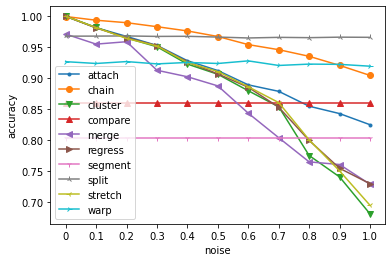

[noise] mean attach: 0.9038961038961039
[noise] mean chain: 0.9454545454545454
[noise] mean cluster: 0.874025974025974
[noise] mean compare: 0.8285714285714286
[noise] mean merge: 0.8831168831168832
[noise] mean regress: 0.887012987012987
[noise] mean segment: 0.7714285714285715
[noise] mean split: 0.9272727272727272
[noise] mean stretch: 0.8844155844155844
[noise] mean warp: 0.7714285714285715


In [25]:
def noise_error(prob, data, robot_str):
    x = correction.error_noise(prob/10, 30, prob/10, data[robot_str].copy())
    return x

e2e_error("noise", noise_error, data)

In [28]:
def slope_error(prob, data, robot_str):
    x = correction.error_slope(prob/10, data[robot_str].copy())
    return x

def shift_error(prob, data, robot_str):
    x = correction.error_shift(prob/10, data[robot_str].copy())
    return x

def withinl_error(prob, data, robot_str):
    x = correction.error_withinline(prob/10, data[robot_str].copy())
    return x

def betweenl_error(prob, data, robot_str):
    x = correction.error_betweenline(prob/10, data[robot_str].copy())
    return x

In [ ]:
# https://stackoverflow.com/questions/2846653/how-can-i-use-threading-in-python#28463266
from multiprocessing.dummy import Pool as ThreadPool
pool = ThreadPool(4)
pool_f = e2e_error
pool_args = [("slope", slope_error, data), ("shift", shift_error, data), ("withinline", withinl_error, data), ("betweenline", betweenl_error, data)]
pool_results = pool.starmap(pool_f, pool_args)


  0%|          | 0/100 [00:00<?, ?it/s]



starting robot_index 0
starting robot_index 0


  0%|          | 0/100 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

starting robot_index 0


starting robot_index 0
robot: 0     error probability: 0
robot: 0     error probability: 0
robot: 0     error probability: 0
robot: 0     error probability: 0
robot: 0     error probability: 1
robot: 0     error probability: 1
robot: 0     error probability: 1
robot: 0     error probability: 1
robot: 0     error probability: 2
robot: 0     error probability: 2
robot: 0     error probability: 2
robot: 0     error probability: 2
robot: 0     error probability: 3
robot: 0     error probability: 3
robot: 0     error probability: 3
robot: 0     error probability: 3
robot: 0     error probability: 4
robot: 0     error probability: 4
robot: 0     error probability: 4
robot: 0     error probability: 4
robot: 0     error probability: 5
robot: 0     error probability: 5
robot: 0     error probability: 5
robot: 0     error probability: 5
robot: 0     error probability: 6
robot: 0     error probability: 6
robot: 0     error probability: 6
robot: 0     error probability: 6
robot: 0     error probab

In [ ]:
pool_results